In [268]:
import pandas as pd
import logging

from tekkieworden.processing.utilities import pandas_join_on_index
from tekkieworden.config import config
from tekkieworden.processing.munge import *

# config
pd.set_option("display.max_columns", 100)

### MBO

In [284]:
def unstack_duo_mbo_files(input_df):
    
        agg_cols = input_df.filter(regex='\d', axis=1).columns.tolist()
        groupby_cols = ['brin_nummer', 'kwalificatie_code', 'kwalificatie_naam']
        agg = input_df.groupby(groupby_cols)[agg_cols].sum()
        logging.info(f"dataframe shape: {agg.shape}")
        
        return agg


def munge_mbo_files():
    
    logging.info("prepare mbo file ingeschrevenen")
    mbo_i = pd.read_csv(str(config.PATH_TO_RAW_DATA) + '/' + config.DUO_MBO_D_CSV, sep=';')
    mbo_i.columns = mbo_i.columns.str.lower().str.replace(" ", "_")
    mbo_rename_i_dict = {'man2015': '2015_man_i',
     'vrouw2015': '2015_vrouw_i',
     'totaal2015': '2015_tot_i',
     'man2016': '2016_man_i',
     'vrouw2016': '2016_vrouw_i',
     'totaal2016': '2016_tot_i',
     'man2017': '2017_man_i',
     'vrouw2017': '2017_vrouw_i',
     'totaal2017': '2017_tot_i',
     'man2018': '2018_man_i',
     'vrouw2018': '2018_vrouw_i',
     'totaal2018': '2018_tot_i',
     'man2019': '2019_man_i',
     'vrouw2019': '2019_vrouw_i',
     'totaal2019': '2019_tot_i'}
    mbo_i = mbo_i.rename(columns=mbo_rename_i_dict)
    
    logging.info("prepare mbo file ingeschrevenen")
    mbo_d = pd.read_csv(str(config.PATH_TO_RAW_DATA) + '/' + config.DUO_MBO_I_CSV, sep=';')
    mbo_d.columns = mbo_d.columns.str.lower().str.replace(" ", "_")
    mbo_rename_d_dict = {'dipman2015': '2015_man_d',
     'dipvrw2015': '2015_vrouw_d',
     'diptotaal2015': '2015_tot_d',
     'dipman2016': '2016_man_d',
     'dipvrw2016': '2016_vrouw_d',
     'diptotaal2016': '2016_tot_d',
     'dipman2017': '2017_man_d',
     'dipvrw2017': '2017_vrouw_d',
     'diptotaal2017': '2017_tot_d',
     'dipman2018': '2018_man_d',
     'dipvrw2018': '2018_vrouw_d',
     'diptotaa2018l': '2018_tot_d',
     'dipman2019': '2019_man_d',
     'dipvrw2019': '2019_vrouw_d',
     'diptotaal2019': '2019_tot_d'}
    mbo_d = mbo_d.rename(columns=mbo_rename_d_dict)
    
    mbo_i_agg = unstack_duo_mbo_files(input_df=mbo_i)
    mbo_d_agg = unstack_duo_mbo_files(input_df=mbo_d)
    
    df = pandas_join_on_index(left_df=mbo_i_agg, right_df=mbo_d_agg, how='left').reset_index()
    df = label_tech_studies(input_df=df, yaml_file='mbo_tech_labels.yml', label_col='kwalificatie_naam')
    
    df = df.query("tech_label != 'no_tech'")
    write_df_csv(input_df=df, filename="opleidingen_mbo_tech_filtered.csv")
    
    return df

In [285]:
mbo = munge_mbo_files()

INFO:root:prepare mbo file ingeschrevenen
INFO:root:prepare mbo file ingeschrevenen
INFO:root:dataframe shape: (12557, 15)
INFO:root:dataframe shape: (14029, 15)
INFO:root:left_df shape: (12557, 15)
INFO:root:right_df shape: (14029, 15)
INFO:root:joining on left_indices: ['brin_nummer', 'kwalificatie_code', 'kwalificatie_naam']
INFO:root:joining on left_key: ['brin_nummer', 'kwalificatie_code', 'kwalificatie_naam']
INFO:root:Join result
	both          11517
left_only      1040
right_only        0
Name: _merge, dtype: int64
INFO:root:joined df: (12557, 30)
INFO:root:Writing 861 records to opleidingen_mbo_tech_filtered.csv


writing to destination: /home/diederik/projects/tekkieworden/packages/tekkieworden/tekkieworden/datasets/munged/opleidingen_mbo_tech_filtered.csv


In [261]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def melt_plot_facet_grid(input_df, dim: str, sexe: str, 
               hue_var: str, groupby_var: str,
               plot_facet_grid= None) -> pd.DataFrame:
    """
    Function to melt pd.Dataframe for plotting purposes
    :param input_df: pd.DataFrame to be melted
    :param dim: dimension to plot:  choose: "i" for ingeschrevenen or "d" for gediplomeerden
    :param sexe: numeric sexe to plot: "man", "vrouw" or "total"
    :param hue_var: HUE variable on wich dimension to split in each plot
    :param groupby_var: value to groupby on
    :return: melted pd.DataFrame or FacetGrid
    """
    dim = dim
    # years differ per ingeschrevenen or gediplomeerden and per update. fix:
    dim_list = tech.filter(regex=rf'_{dim}$').columns.tolist()
    years = np.unique(list(map(lambda sub:int(''.join( 
            [x for x in sub if x.isnumeric()])), dim_list)))
    
    if sexe == 'man':
        dim_cols = [f"{years[0]}_man_{dim}", f"{years[1]}_man_{dim}", f"{years[2]}_man_{dim}",
        f"{years[3]}_man_{dim}", f"{years[4]}_man_{dim}"]
    elif sexe == 'vrouw':
        dim_cols = [f"{years[0]}_vrouw_{dim}", f"{years[1]}_vrouw_{dim}", f"{years[2]}_vrouw_{dim}",
        f"{years[3]}_vrouw_{dim}", f"{years[4]}_vrouw_{dim}"]
    elif sexe == 'total':
        dim_cols = [f"{years[0]}_tot_{dim}", f"{years[1]}_tot_{dim}", f"{years[2]}_tot_{dim}",
        f"{years[3]}_tot_{dim}", f"{years[4]}_tot_{dim}"]
            
    id_vars = [groupby_var, hue_var]
    value_name = "".join(["ingeschreven" if x == 'i' else 'gediplomeerden' for x in dim])
    
    melt_frame = (
        pd.melt(
            frame=input_df,
            id_vars=id_vars,
            value_vars=dim_cols,
            var_name=sexe,
            value_name=value_name
        )
        .sort_values(
            by=[
                groupby_var,
                hue_var,
                sexe,
            ]
        )
        .groupby([groupby_var, hue_var, sexe])
        .agg({value_name: "sum"})
        .reset_index()
    )
    melt_frame[sexe] = (melt_frame[sexe]
        .apply(lambda x : re.sub("[^0-9]", " ", x)))
    melt_frame[sexe] = melt_frame[sexe].astype(int)
    
    if plot_facet_grid:
        
        no = len(melt_frame[hue_var].unique())
        palette = dict(zip(melt_frame[hue_var].unique(), sns.color_palette("rocket_r", no)))

        grid = sns.FacetGrid(
            melt_frame,
            col=groupby_var,
            palette=palette,
            col_wrap=4,
            hue=hue_var,
            sharex=False,
            sharey=False,
            height=5,
            aspect=1.5,
        )

        grid.map(plt.axhline, y=melt_frame[value_name].mean(), ls=":", c=".5")
        grid.map(plt.plot, sexe, value_name, marker="o")
        grid.add_legend()

        for ax in grid.axes.flat:
            _ = plt.setp(
                ax.get_xticklabels(), visible=True, size=12
            )  ## set proporty of an artist object
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
                        
        return grid
    
    return melt_frame

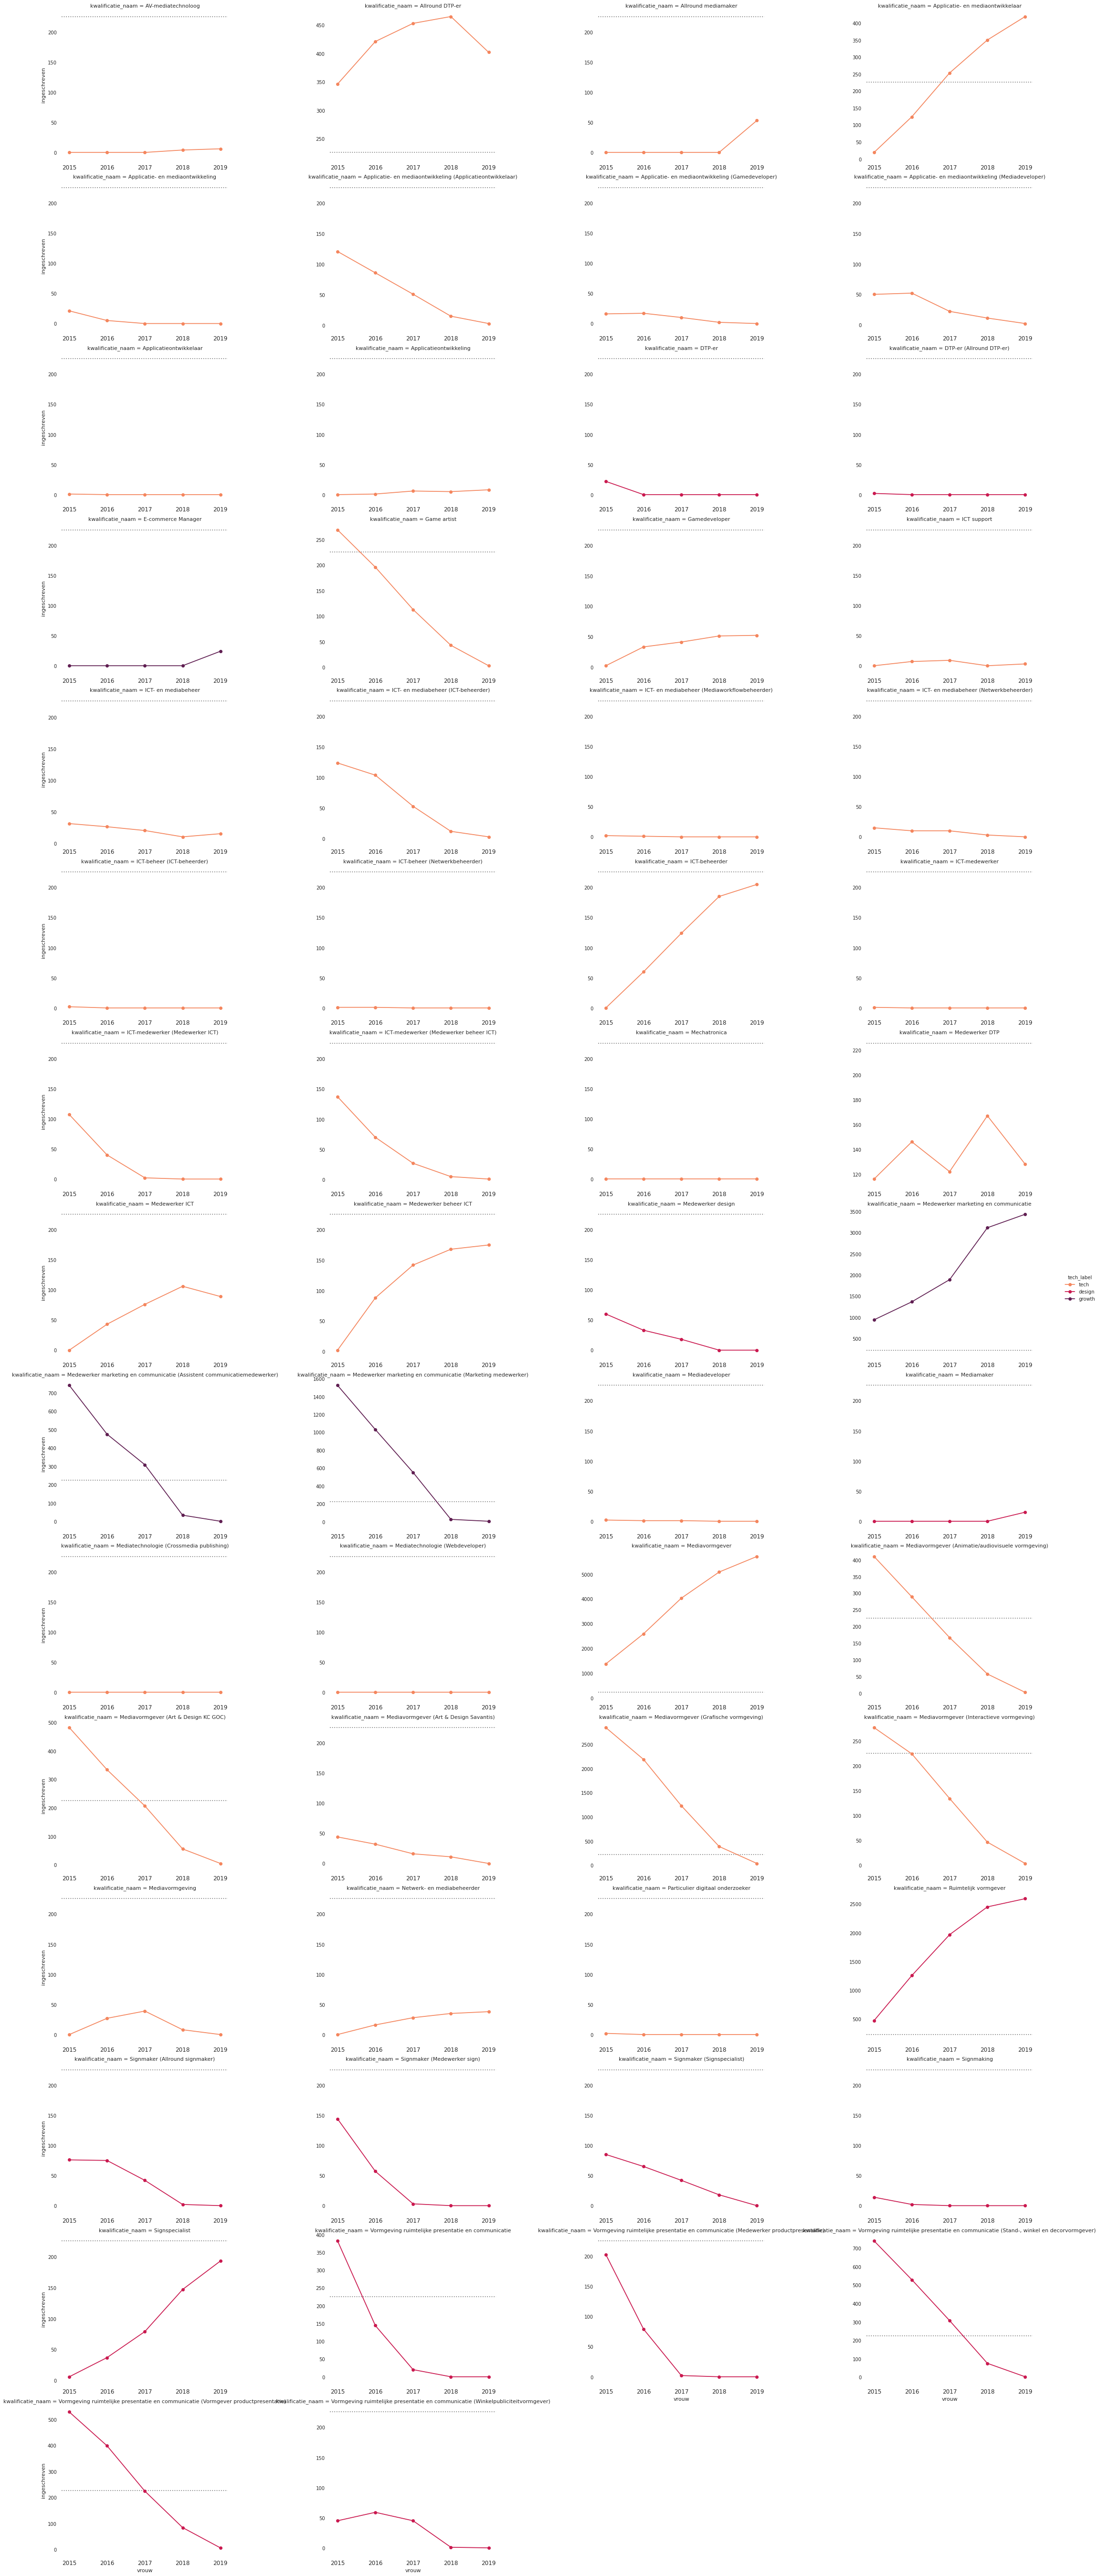

In [267]:
t = melt_plot_facet_grid(input_df=df[df.tech_label != 'no_tech'], dim = 'i', sexe='vrouw', 
               hue_var='tech_label', 
               groupby_var='kwalificatie_naam', plot_facet_grid=True)

In [252]:
t

,brin_nummer,tech_label,vrouw,ingeschreven
0,00GT,growth,2015,173.0
1,00GT,growth,2016,167.0
2,00GT,growth,2017,143.0
3,00GT,growth,2018,122.0
4,00GT,growth,2019,107.0
5,00GT,no_tech,2015,11221.0
6,00GT,no_tech,2016,10936.0
7,00GT,no_tech,2017,11268.0
8,00GT,no_tech,2018,11575.0
9,00GT,no_tech,2019,12047.0


In [223]:
t.dtypes

brin_nummer      object
tech_label       object
vrouw             int64
ingeschreven    float64
dtype: object